# (Company Name>) Financial Modelling
Financial modelling for your company.

## Main Configuration
Set these parameters

In [5]:
from datetime import date, datetime, timedelta
def parse_date(val):
    if isinstance(val, date):
        return val
    return datetime.strptime(val, "%Y-%m-%d").date()

# Set your initial parameters for the simulation
start_date              = parse_date("2024-01-28")
end_date                = parse_date("2025-07-01")
start_balance           = 250000


## Simulation
Edit your "components" in the components directory, then run this.

In [6]:
import os
import yaml
import pandas as pd

pd.set_option('display.max_rows', 200)

# As of 28th Jan
exchange_rates = {
    'USD': 1.52,
    'GBP': 1.93   
}

def convert_to_aud(amount, from_currency):
    if from_currency == 'AUD':
        return amount

    if from_currency not in exchange_rates:
        raise ValueError("Unsupported currency or missing exchange rate.")

    # Get the exchange rate from the specified currency to AUD
    rate_to_aud = exchange_rates[from_currency]

    # Convert the amount to AUD
    amount_in_aud = amount * rate_to_aud
    return amount_in_aud


def parse_date(val):
    if isinstance(val, date):
        return val
    return datetime.strptime(val, "%Y-%m-%d").date()

def add_months(start_date, months):
    new_month = start_date.month - 1 + months
    year = start_date.year + new_month // 12
    month = new_month % 12 + 1
    day = min(start_date.day, [31, 29 if year % 4 == 0 and not year % 400 == 0 else 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31][month - 1])
    return datetime(year, month, day).date()


def add_years(start_date, years):
    year = start_date.year + years
    month = start_date.month - 1
    day = min(start_date.day, [31, 29 if year % 4 == 0 and not year % 400 == 0 else 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31][month - 1])
    return datetime(year, month, day).date()

def load_yaml_directory(directory):
    objects = []
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.yaml') or filename.endswith('.yml'):
                filepath = os.path.join(dirpath, filename)
                with open(filepath, 'r') as file:
                    contents = yaml.safe_load(file)
                    objects.append(contents)
    return objects

# Generate events generates the expense events
def generate_events(object, end_date):
    events = []
    if not object['enabled'] or len(object['payment_schedule']) == 0:
        return events
    
    # Start off at the payment first date
    current_date = parse_date(object['start_date'])
    if 'align_date' in object:
        current_date = parse_date(object['align_date']) # Use adjusted start date to make payroll dates consistent

    payment_schedule_index = 0

    for payment_schedule in object['payment_schedule']:
        if payment_schedule['action'] == "stop":
            # We've reached the end of the schedule
            break
        elif payment_schedule['action'] == 'once':
            amount = convert_to_aud(payment_schedule['amount'], object['currency'])
            if 'divisor' in payment_schedule:
                amount /= payment_schedule['divisor']
            if 'scalar' in payment_schedule:
                amount *= payment_schedule['scalar']

            if object['type'] == 'Expense':
                amount *= -1

            events.append({
                'date':     parse_date(payment_schedule['date']),
                'type':     object['type'],
                'category': object['category'],
                'provider': object['provider'],
                'description': object['description'],
                'amount':   amount,
                'note':     note,
            })       

        elif payment_schedule['action'] =="repeat":
            # Work out how long this payment schedule is in effect for
            iterate_until = end_date # Assume forever
            if 'until' in payment_schedule:
                schedule_stop = parse_date(payment_schedule['until'])
                if schedule_stop < end_date:
                    iterate_until = schedule_stop
                
            amount = convert_to_aud(payment_schedule['amount'], object['currency'])
            if 'divisor' in payment_schedule:
                amount /= payment_schedule['divisor']
            if 'scalar' in payment_schedule:
                amount *= payment_schedule['scalar']

            if object['type'] == 'Expense':
                amount *= -1

            while current_date <= iterate_until:

                note = payment_schedule['note']

                # Advance date
                interval = 1
                if 'interval' in payment_schedule:
                    interval = payment_schedule['interval']

                match payment_schedule['frequency']:
                    case "yearly":
                        current_date = add_years(current_date, interval)
                    case "monthly":
                        current_date = add_months(current_date, interval)
                    case "weekly":
                        current_date += timedelta(weeks=interval)
                    case "daily":
                        current_date += timedelta(days=interval)
                if current_date < iterate_until:
                    events.append({
                        'date':     current_date,
                        'type':     object['type'],
                        'category': object['category'],
                        'provider': object['provider'],
                        'description': object['description'],
                        'amount':   amount,
                        'note':     note,
                    })             

    return events


# Load our objects
components              = load_yaml_directory("./components")

ledger = []
ledger.append({
    'date': start_date + timedelta(days=-1),
    'type': 'Adjustment',
    'category': 'Banking',
    'provider': '',
    'amount':   start_balance,
    'description': 'Initial balance',
    'note': 'As of previous business date.'
})
for component in components:
    for event in generate_events(component, end_date):
        if event['date'] >= start_date and event['date'] <= end_date:
            ledger.append(event)

generate_events(components[0], end_date)

df = pd.DataFrame(ledger)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['date', 'type', 'category', 'provider'])
df['amount'] = df['amount'].round(2)
df['running_balance'] = df['amount'].cumsum()
df.set_index('date', inplace=True)


df.to_csv('ledger_forecast.csv', index=True)

df

,type,category,provider,amount,description,note,running_balance
date,,,,,,,
2024-01-27,Adjustment,Banking,,250000.00,Initial balance,As of previous business date.,250000.00
2024-02-01,Expense,Office Expenses,RentalCorp,-4500.00,Office Rental,None,245500.00
2024-02-18,Expense,Employees and Contractors,Jack Smith,-5336.54,Sales,Fortnightly salary,240163.46
2024-02-18,Expense,Employees and Contractors,Jane Doe,-4269.23,Software Engineer,Fortnightly salary,235894.23
2024-03-01,Expense,Office Expenses,RentalCorp,-4500.00,Office Rental,None,231394.23
2024-03-01,Revenue,Clients,CustomerCorp,15000.00,Monthly contract,Monthly payment,246394.23
2024-03-03,Expense,Employees and Contractors,Jack Smith,-5336.54,Sales,Fortnightly salary,241057.69
2024-03-03,Expense,Employees and Contractors,Jane Doe,-4269.23,Software Engineer,Fortnightly salary,236788.46
2024-03-17,Expense,Employees and Contractors,Jack Smith,-5336.54,Sales,Fortnightly salary,231451.92


## Visualisations
Some graphs showing your running balance and cashflow.

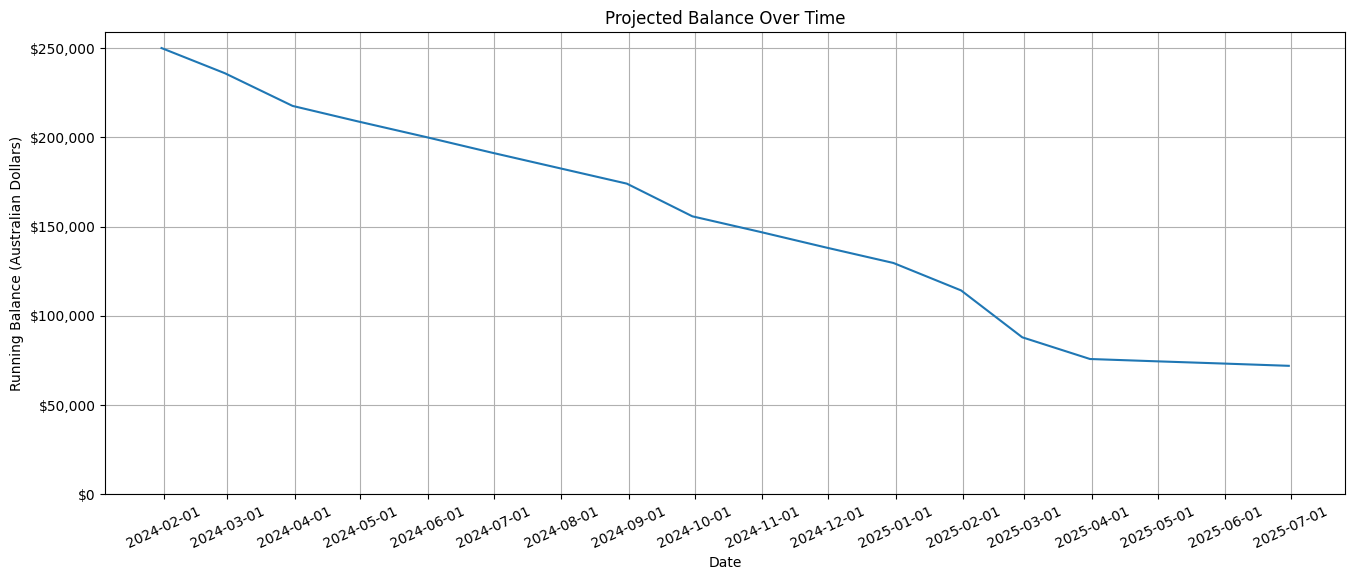

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

def dollar_formatter(x, pos):
    return f'${x:,.0f}'

df_resampled = df.resample('M').last()

# Plotting
plt.figure(figsize=(16, 6))
plt.plot(df_resampled.index, df_resampled['running_balance'], marker='', linestyle='-')

# Formatting the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_formatter))
plt.gca().set_ylim(bottom=0) 

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Running Balance (Australian Dollars)')
plt.title('Projected Balance Over Time')
plt.xticks(rotation=25)
plt.grid(True)

# Show plot
plt.show()

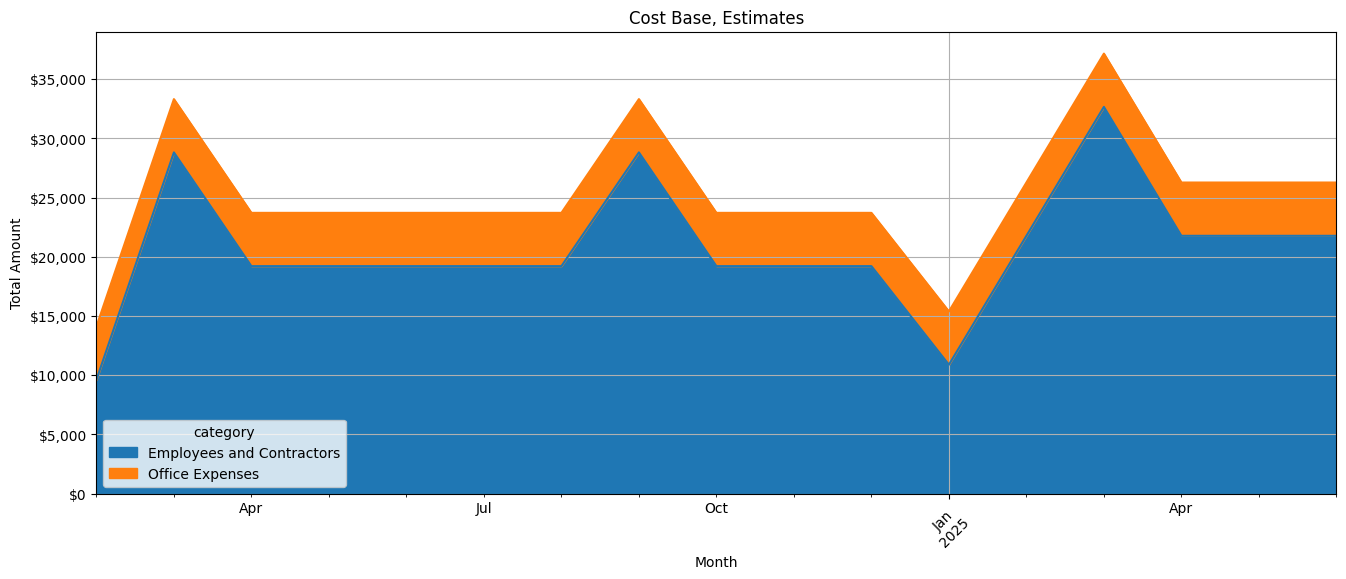

In [8]:
# Filter to only rows with negative amounts
negative_df = df[df['amount'] < 0]
# Group by 'category' and month, and sum the absolute values of amounts
grouped = negative_df.groupby([negative_df['category'], negative_df.index.to_period('M')])['amount'].sum().abs().reset_index()

# Pivot the table for the stacked area chart
pivot_df = grouped.pivot_table(index='date', columns='category', values='amount', fill_value=0)

pivot_df

# Stacked area plot
plt.figure(figsize=(16, 6))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_formatter))
pivot_df.plot(kind='area', stacked=True, ax=plt.gca())

# Adding labels and title
plt.title('Cost Base, Estimates')
plt.ylabel('Total Amount')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()